# Table of contents
1. [Libraries](#libraries)
2. [Question](#quesion)
3. [Data Preparation](#preparation)
4. [Modelling](#modelling)
5. [Evaluation](#evaluation)

<h1 id ="libraries">1. Libraries </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

<h1 id="question">2. Question</h1>

**A question:** Predict the gross of movies

**Answering this question will help us:**
- Understand the key factors that influence movie gross revenue.
- Make informed decisions on budget allocation, marketing strategies, and release timing.
- Identify trends and patterns in the movie industry that can be leveraged for future projects.

**How to answer:**
1. **Data Collection and Preprocessing:**
   - Collect data on various features such as budget, genre, cast, director, studio, release date, and previous gross revenue.
   - Handle missing values by imputing numerical columns with their mean and categorical columns with 'Unknown'.
   - Apply log transformation to monetary values to handle skewness.
   - One-hot encode categorical variables like genre, rating, studio, director, and cast.
   - Standard scale numerical variables to ensure they are on a similar scale.

2. **Model Building:**
   - Use XGBoost, a powerful gradient boosting algorithm, to build the regression model.
   - Split the data into training and testing sets.
   - Train the model on the training set and make predictions on the testing set.

3. **Model Evaluation:**
   - Evaluate the model using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) score.
   - Perform K-fold cross-validation to ensure the model's robustness and generalizability.
   - Analyze feature importance to understand which factors contribute most to predicting movie gross revenue.

4. **Deployment:**
   - Input the real test into each model to see how it predicts


<h1 id = 'preparation'>3. Data Preparation </h1>

In [2]:
data = pd.read_csv('../Data/preprocessed_data.csv')

In [3]:
data['Total Gross'] = data['Worldwide Gross'] + data['Domestic Gross']

- Check for skewness

In [4]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  2.716733700616222
Worldwide Gross:  4.833655536153712
Domestic Gross:  3.845856866276893
Total Gross:  4.528670983843642


As can be seen, the skewness in 3 economic features is heavily positively skewed, therefore we need to **log transform** these features. 

However, before log transform we will need to multiply the inflation rate of each year to have the accurate calculation and analysis

- Multiply the inflation rate

In [5]:
# Read the inflation data into a DataFrame
inflation_data = pd.read_csv('../Data/inflation_rate.csv')

# Create DataFrame for inflation data
inflation_df = pd.DataFrame(inflation_data)

data['Year'] = pd.to_datetime(data['Release Date']).dt.year
data['Month'] = pd.to_datetime(data['Release Date']).dt.month

# Merge inflation data with your movie data on 'Year'
data = data.merge(inflation_df, on='Year', how='left')

# Adjust the economic columns by dividing them by the 'Unit' (inflation adjustment factor)
economic_features = ['Production Budget', 'Domestic Gross', 'Worldwide Gross', 'Total Gross']

for feature in economic_features:
    data[feature] = data[feature] * (data['Unit'] / data['Unit'].iloc[-1])

# The adjusted columns will now reflect the true values after inflation adjustment

- Apply log transformation

In [6]:
data['Production Budget'] = (data['Production Budget'] + 1).apply(np.log)
data['Worldwide Gross'] = (data['Worldwide Gross'] + 1).apply(np.log)
data['Domestic Gross'] = (data['Domestic Gross'] + 1).apply(np.log)
data['Total Gross'] = (data['Total Gross'] + 1).apply(np.log)

In [7]:
# Check the skewness of production budget and worldwide/domestic gross
print('Production Budget: ',data['Production Budget'].skew())
print('Worldwide Gross: ', data['Worldwide Gross'].skew())
print('Domestic Gross: ', data['Domestic Gross'].skew())
print('Total Gross: ', data['Total Gross'].skew())

Production Budget:  -1.241663317451469
Worldwide Gross:  -2.3151114555660994
Domestic Gross:  -1.9259857971548238
Total Gross:  -2.3703920346053122


After the transformation, the features now exhibit negative skewness, which is still acceptable for many regression models.

- Check the distribution of Total Gross 

Text(0, 0.5, 'Frequency')

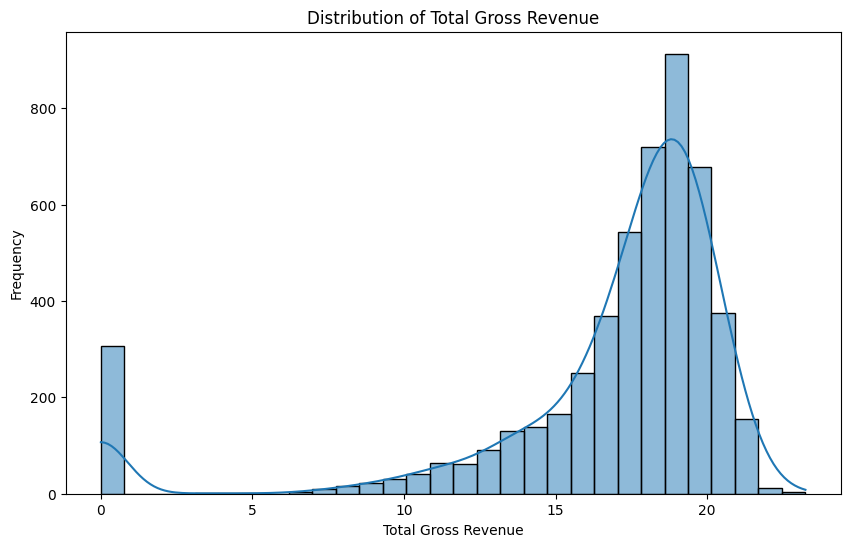

In [8]:
# Plot the distribution of total gross revenue
plt.figure(figsize=(10, 6))
sns.histplot(data['Total Gross'], bins=30, kde=True)
plt.title('Distribution of Total Gross Revenue')
plt.xlabel('Total Gross Revenue')
plt.ylabel('Frequency')

Unexpectedly, there are a huge number of films that have revenue is 0, this can be because, some of films' revenues were not recorded. Therefore, we decided to delete movies having revenue equals to 0

In [9]:
data = data[data['Total Gross'] > 0]

data = data.reset_index(drop=True)

In [10]:
# Define the numerical and categorical features
numerical_features = ['Tomatoes CriticScore', 'Tomatoes UserScore',
                      'Production Budget', 'Metascore', 'Meta UserScore']
categorical_features = ['Genre', 'Rating', 'Studio', 'Year', 'Month']


X = data[numerical_features+categorical_features]
y = data['Total Gross']


- Feature selection for numerical columns

In order to decide which numerical features should be used, we choose **ANOVA Test** for these reasons:
1. **Identifies Significant Features:**

    - ANOVA (Analysis of Variance) tests the statistical significance of each feature with respect to the target variable.
    - It helps identify features that have a strong relationship with the target variable.

2. **Handles Numerical Features:**

    - ANOVA is suitable for numerical features, making it a good choice for datasets with continuous variables.

3. **Improves Model Performance:**
    - By selecting the most significant features, it reduces the dimensionality of the dataset.
    - This can lead to improved model performance and reduced overfitting.

4. **Interpretability:**
    - The ANOVA scores provide a clear indication of the importance of each feature.
    - This helps in understanding which features contribute most to the prediction.

Steps to do:
1. Split Data into Train and Test Sets.
2. Use SelectKBest with the f_classif function to perform the ANOVA test and select the top features.

In [11]:
X_train_for_select, X_test_for_select, y_train_for_select, y_test_for_select = train_test_split(X, y, test_size=0.2, random_state=42)

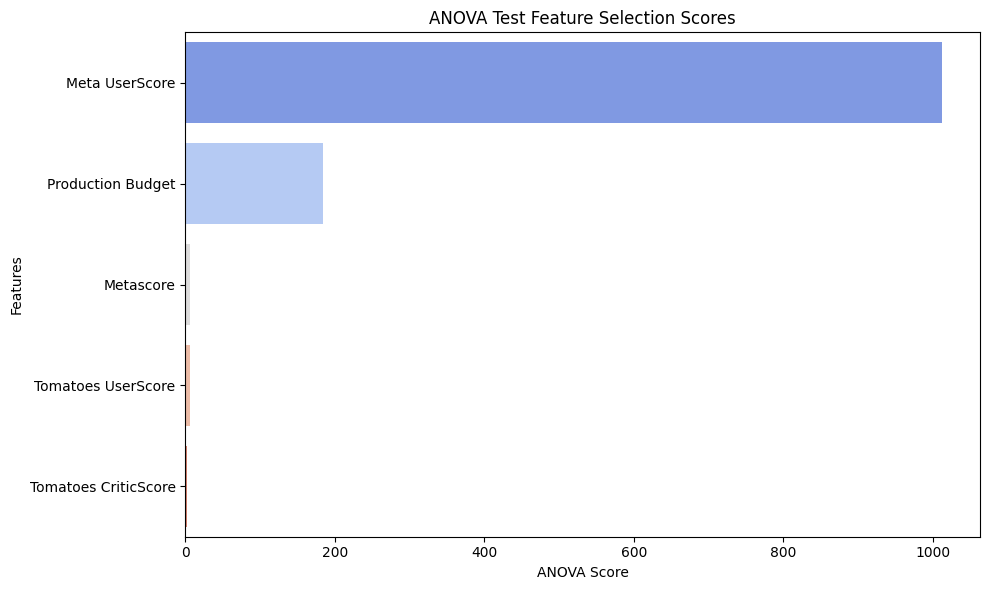

In [12]:
from sklearn.feature_selection import f_classif

X_numerical = X_train_for_select[numerical_features]  # Use column names directly

# Fit SelectKBest with chi2
selector = SelectKBest(f_classif, k=5)
selector.fit(X_numerical, y_train_for_select)

# Get Chi2 scores
scores = pd.DataFrame(data=selector.scores_, index=numerical_features, columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Barplot for better visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=scores['score'], y=scores.index, palette='coolwarm', hue=scores.index, legend=False)
plt.title('ANOVA Test Feature Selection Scores')
plt.xlabel('ANOVA Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Although we can see only `Meta UserScore` and `Production Budget` have the highest scores, we still keep 3 remaining scores, because 
- After trials we concluded that these have correlation with each other (the metrics improved dramatically when these features are all included). 
- Domain Knowledge: consider the relevance of each feature based on domain knowledge, even if a feature has a lower ANOVA score, it might still be important from a business or domain perspective.

In [13]:
n_director = 10 # One hot encoding for top 10 director with most movies
n_cast = 20 # One hot encoding for top 20 cast with most movies
n_studio = 50 # One hot encoding for top 50 studio with most movies

- Feature selection for categorical columns

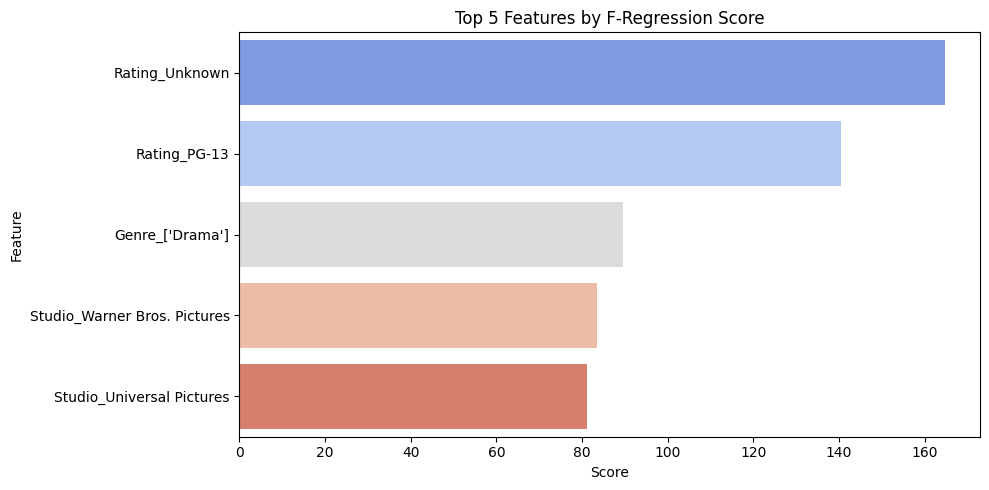

In [14]:
# One-hot encode categorical features

X_categorical = X_train_for_select[categorical_features]  # Use column names directly
X_categorical = X_categorical.fillna(0)

X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# Fit SelectKBest with f_regression
selector = SelectKBest(f_regression, k=5)
selector.fit(X_categorical_encoded, y_train_for_select)

# Get scores
scores = pd.DataFrame(data=selector.scores_, 
                      index=X_categorical_encoded.columns, 
                      columns=['score'])
scores = scores.sort_values(by='score', ascending=False)

# Get the top 5 features
top_5_categorical = scores.head(5).index.tolist()

# Plot the top 5 scores
plt.figure(figsize=(10, 5))
sns.barplot(y=scores.head(5).index, x=scores.head(5)['score'], palette='coolwarm', hue=scores.head(5).index, legend=False)
plt.title('Top 5 Features by F-Regression Score')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


As can be seen from the plot, some members of **`Genre`** and **`Rating`** shows up in top 5 F-Regression Score, therefore we will need to include these columns for modelling, however, we don't see any of **`Cast`** and **`Director`**. So we will need to use some plots to see actually whether it has any correlations with revenue

As can be seen from the plot, some members of **`Genre`** and **`Rating`** shows up in top 5 F-Regression Score, therefore we will need to include these columns for modelling, however, we don't see any of **`Cast`** and **`Director`**. So we will need to use some plots to see actually whether it has any correlations with revenue

Text(0.5, 0, 'Cast Quality')

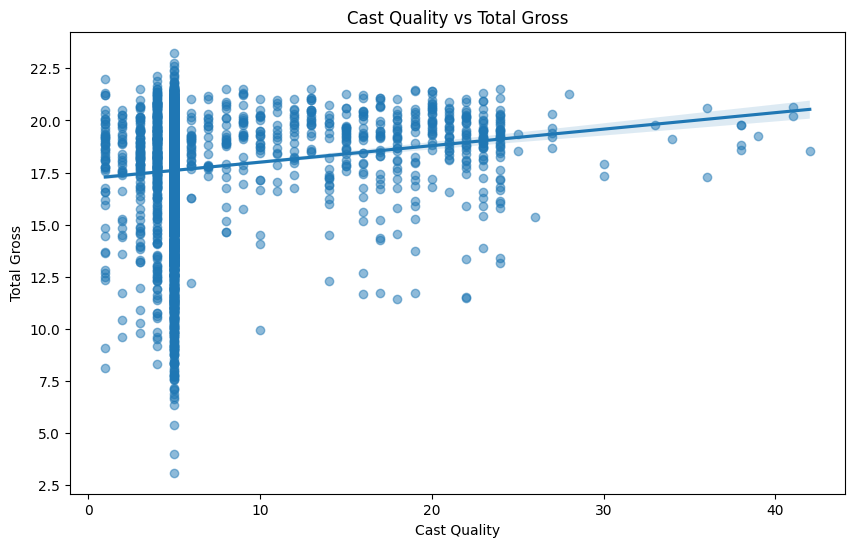

In [15]:
def reformat_cast(cast_string):
    cast_string = cast_string.replace('[','').replace(']','').replace('"','')
    cast_list = [cast.strip().strip("'") for cast in cast_string.split(',')]
    return cast_list


# Create a temporary copy of the data
data_tmp = data.copy()

# Split the 'Cast' column into a list of cast members
data_tmp['Cast'] = data_tmp['Cast'].apply(reformat_cast)

# Get the top 20 cast members
top_cast = data_tmp['Cast'].explode().value_counts().nlargest(20)

# Create a mapping for the top cast members (the more famous cast get higher values)
map_top_cast = {cast: i for i, cast in zip(range(len(top_cast), 0, -1), top_cast.index)}

# Encode the 'Cast' column to calculate the quality of the cast for each movie
def encode_cast(cast):
    quality_score = 0
    # Iterate through each cast member of the movie
    for member in cast:
        # Add the value of the cast member if they are in the top 20
        if member in map_top_cast:
            quality_score += map_top_cast[member]
        else:
            # For members not in the top 20, give them a default score of 1
            quality_score += 1
    return quality_score

# Apply the function to calculate the quality of the cast for each movie
data_tmp['Cast_Quality'] = data_tmp['Cast'].apply(encode_cast)

# Plot the regplot of the 'Cast_Quality' and 'Total Gross' columns
plt.figure(figsize=(10, 6))
sns.regplot(x='Cast_Quality', y='Total Gross', data=data_tmp, scatter_kws={'alpha': 0.5})
plt.title('Cast Quality vs Total Gross')
plt.xlabel('Cast Quality')



In [16]:
print(data_tmp[['Cast_Quality', 'Total Gross']].corr())

              Cast_Quality  Total Gross
Cast_Quality      1.000000     0.130987
Total Gross       0.130987     1.000000


From the scatter plot, we can observe a weak positive trend, as indicated by the regression line, suggesting that there is a small positive correlation between Cast Quality and Total Gross. However, the data points are widely scattered, and the regression line is not steep, which indicates that Cast Quality alone does not strongly predict Total Gross.
Therefore, we will remove it

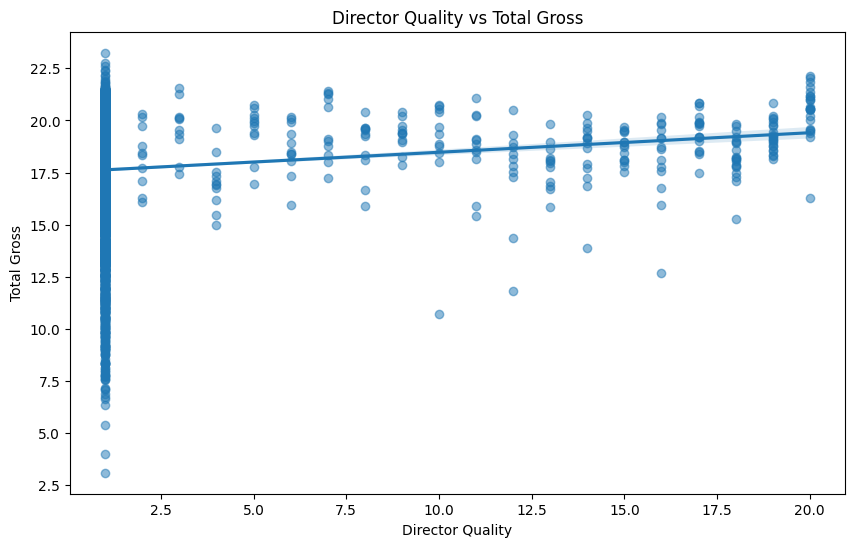

In [17]:
def reformat_director(director_string):
    # Remove unwanted characters and split the director string into a list
    director_string = director_string.replace('[','').replace(']','').replace('"','')
    director_list = [director.strip().strip("'") for director in director_string.split(',')]
    return director_list


# Create a temporary copy of the data
data_tmp = data.copy()

# Split the 'Director' column into a list of directors
data_tmp['Director'] = data_tmp['Director'].apply(reformat_director)

# Get the top 20 directors (most frequent directors)
top_directors = data_tmp['Director'].explode().value_counts().nlargest(20)

# Create a mapping for the top directors (more famous directors get higher values)
map_top_directors = {director: i for i, director in zip(range(len(top_directors), 0, -1), top_directors.index)}

# Encode the 'Director' column to calculate the quality of the director for each movie
def encode_director(directors):
    quality_score = 0
    # Iterate through each director of the movie
    for director in directors:
        # Add the value of the director if they are in the top 20
        if director in map_top_directors:
            quality_score += map_top_directors[director]
        else:
            # For directors not in the top 20, give them a default score of 1
            quality_score += 1
    return quality_score

# Apply the function to calculate the quality of the director for each movie
data_tmp['Director_Quality'] = data_tmp['Director'].apply(encode_director)

# Plot the regplot of the 'Director_Quality' and 'Total Gross' columns
plt.figure(figsize=(10, 6))
sns.regplot(x='Director_Quality', y='Total Gross', data=data_tmp, scatter_kws={'alpha': 0.5})
plt.title('Director Quality vs Total Gross')
plt.xlabel('Director Quality')
plt.ylabel('Total Gross')
plt.show()


In [18]:
print(data_tmp[['Director_Quality', 'Total Gross']].corr())

                  Director_Quality  Total Gross
Director_Quality          1.000000     0.104463
Total Gross               0.104463     1.000000


The scatter plot shows a weak positive correlation between Director Quality and Total Gross. This means that as Director Quality increases, Total Gross tends to increase slightly, but the relationship is not very strong. So, we will remove it as well

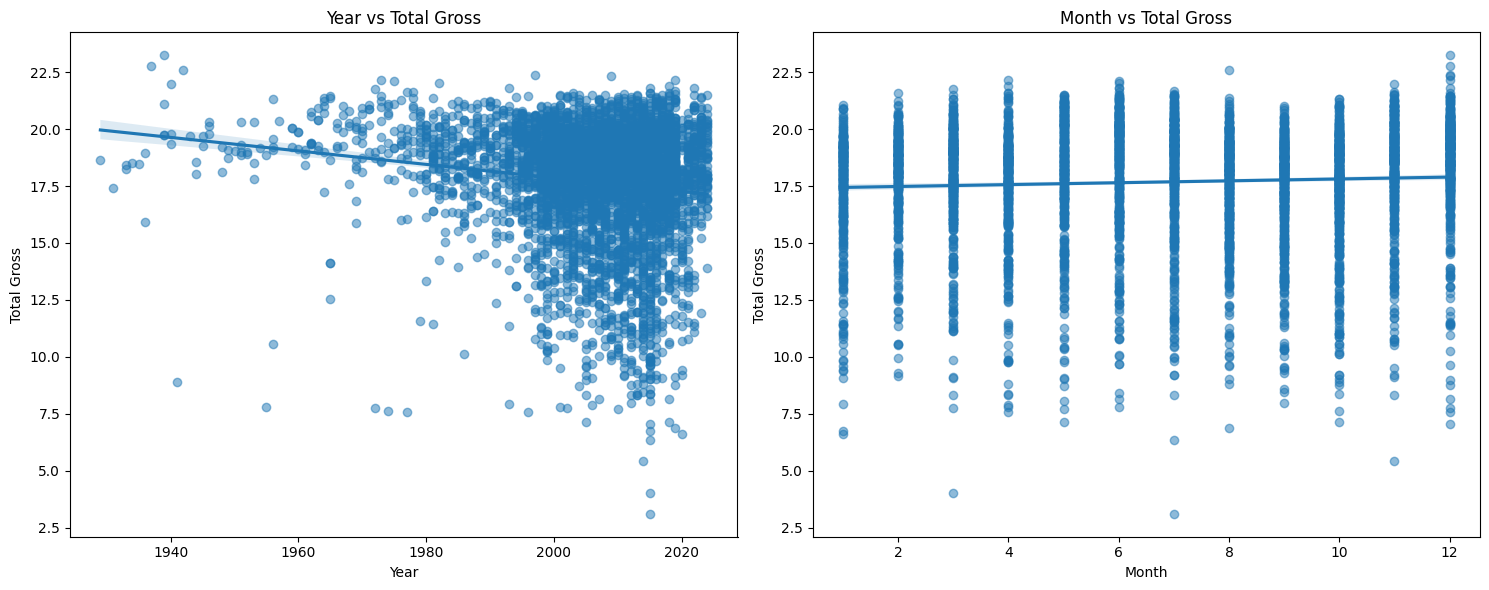

In [19]:
# Create a figure with 2 subplots arranged horizontally
data_tmp = data.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Year vs Total Gross
sns.regplot(x='Year', y='Total Gross', data=data_tmp, ax=ax1, scatter_kws={'alpha': 0.5})
ax1.set_title('Year vs Total Gross')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Gross')

# Plot Month vs Total Gross
sns.regplot(x='Month', y='Total Gross', data=data_tmp, ax=ax2, scatter_kws={'alpha': 0.5})
ax2.set_title('Month vs Total Gross')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Gross')

plt.tight_layout()
plt.show()

In [20]:
print(data_tmp[['Year', 'Total Gross']].corr())
print(data_tmp[['Month', 'Total Gross']].corr())

                 Year  Total Gross
Year         1.000000    -0.144945
Total Gross -0.144945     1.000000
                Month  Total Gross
Month        1.000000     0.054402
Total Gross  0.054402     1.000000


Although, the correlation between Year and Month and Total Gross is weak, we still keep it because both features relevant for movie industry. But we need to modify it into bin to reduce potential noise while preserving temporal information

- Categorical encoding and numerical scaling

1. Handling Missing Values
2. Reforming and encoding Categorical Variables
    - **`Genre`** is reformatted from a string representation of a list to an actual list of genres. Then, one-hot encoding is applied to each unique genre
    - **`Rating`** is one-hot encoded using OneHotEncoder
    - **`Studio`** is one-hot encoded for the top n_studio studios (Which movie produced by top studio (has the top highest number of movies produced) is labeled 1 ), with other studios grouped into 'Studio Other'
    - **`Director`** and **`Cast`** are one-hot encoded as the same for **`Studio`**, although we don't use this feature, we still leave there if needed in future
    - **`Year`** and **`Month`** are binned into 10 years and 3 months respectively, to catch the trend of movies 

3. Standard Scale for Numerical Variables
    - Although all tree-based models don't necessarily require Standard Scale, we still use it because it can help:
        - Regularization in some implementations
        - Model convergence speed
        - Numerical stability

In [21]:
data = data.dropna(subset=['Total Gross'])



def reformat_genre(genre_string):
    genre_string = genre_string.replace('[','').replace(']','').replace('"','')
    genre_list = [genre.strip().strip("'") for genre in genre_string.split(',')]
    return genre_list

X['Genre'] = X['Genre'].apply(reformat_genre)

#Get unique
unique_genres = set(genre for sublist in X['Genre'] for genre in sublist)

#One hot encoding Genre
for genre in unique_genres:
    X[f'Genre_{genre}'] = X['Genre'].apply(lambda x: 1 if genre in x else 0)

X = X.drop(columns=['Genre'])

#One hot encoding Rating
unique_ratings = X['Rating'].unique()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(X[['Rating']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Rating']))

X = pd.concat([X, encoded_df], axis=1).drop(['Rating'], axis=1)

if 'Studio' in X.columns:

  n_tops = n_studio

  top_studios = X['Studio'].value_counts().nlargest(n_tops)

  X['Studio'] = X['Studio'].apply(lambda x: x if x in top_studios else 'Other')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Studio']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Studio']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Studio'], axis=1)

if 'Director' in X.columns:

  n_top = n_director

  top_directors = X['Director'].value_counts().nlargest(n_top)
  X['Director'] = X['Director'].apply(lambda x: x if x in top_directors else 'Director Other')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Director']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Director']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Director'], axis=1)

def bin_years(data, column, bins=11, future_year=2024):
    """
    Bin years with padding for future years
    """
    min_year = data[column].min()
    max_year = max(data[column].max(), future_year)  # Include 2024

    bin_edges = np.linspace(min_year, max_year, bins + 1)
    bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]
    binned_years = pd.cut(data[column], bins=bin_edges, labels=bin_labels, include_lowest=True)
    return binned_years

if 'Year' in X.columns:
    n_bins = 11

    X['Year'] = bin_years(X, 'Year', bins=n_bins, future_year=2024)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(X[['Year']])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Year']))
    X = pd.concat([X, encoded_df], axis=1).drop(['Year'], axis=1)

#Reformat cast string into list
def reformat_cast(cast_string):
    if pd.isna(cast_string):
        return []
    cast_string = cast_string.replace('[','').replace(']','').replace('"','')
    cast_list = [cast.strip().strip("'") for cast in cast_string.split(',')]
    return cast_list

if 'Cast' in X.columns:

  n_top = n_cast  #Perform one hot for n_cast with most movies

  X['Cast'] = X['Cast'].apply(reformat_cast)
  top_cast = X['Cast'].explode().value_counts().nlargest(n_top)
  for cast in top_cast.index:
      X[f'Cast_{cast}'] = X['Cast'].apply(lambda x: 1 if cast in x else 0)
  X = X.drop(columns=['Cast'])

def bin_months(data, column):
    """
    Bin months with special handling for winter months (December-January)
    """
    def assign_month_group(month):
        if month in [12, 11, 1]:
            return '11_1'
        elif month in [2, 3, 4]:
            return '2_4'
        elif month in [5, 6, 7]:
            return '5_7'
        elif month in [8, 9, 10]:
            return '8_10'

    return data[column].apply(assign_month_group)

if 'Month' in X.columns:

    #Perform one hot encoding
  X['Month'] = bin_months(X, 'Month')
  encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  encoded_features = encoder.fit_transform(X[['Month']])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Month']))
  X = pd.concat([X, encoded_df], axis=1).drop(['Month'], axis=1)

# Standard scaler for numerical features
scaler_for_x = StandardScaler()
scaler_for_y = StandardScaler()
X[numerical_features] = scaler_for_x.fit_transform(X[numerical_features])
y = scaler_for_y.fit_transform(y.values.reshape(-1, 1)).flatten()


In [22]:
X = X[sorted(X.columns)]

In [23]:
X.to_csv('test.csv', index=False)

<h1 id = "modelling">4. Modelling</h1>

**First, we need to spilt the dataset into train and test set**
- **Purpose:**
    1. `Evaluate Model Performance`: Test the model on unseen data to assess its generalization ability.
    2. `Prevent Overfitting`: Ensure the model does not simply memorize the training data by validating it on a separate test set.
    3. `Maintain Data Independence`: Keep the training and testing processes independent to avoid data leakage.
    4. `Reproducibility`: Ensures consistent data splits for reliable comparisons.
- **Train and test set size:**
    - **Train Set:** 80% of the data is used for training the model.
    - **Test Set:** The remaining 20% is reserved for evaluating model performance.


In [24]:
result = [] # Store the results of each model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- XGBoost

1. **Description**
    - XGBoost (eXtreme Gradient Boosting) is an optimized gradient boosting algorithm that:
        - Builds trees sequentially, each correcting errors of previous trees.
        - Uses gradient descent to minimize loss function.
        - Employs regularization to prevent overfitting.

2. **Parameter**
    - `n_estimators`: Number of trees to build, in this model we will use 100, which is quite sufficient for our size of dataset.
    - `learning_rate`: Step size shrinkage to prevent overfitting by scaling the contribution of each tree.
    - `max_depth`: Maximum depth of each tree, controlling model complexity, in this case, we will use the default value 3
    - `random_state`: Ensures reproducibility by fixing the random seed, in this case, we will use 42 to get the same output the first time you make the split.
    - `objective`: Specifies the loss function to minimize, in this case 'reg:squarederror': (mean squared error for regression).

3. **Workflow**
    - **Base Model**: Starts with a weak learner, typically a decision tree.
    - **Residual Calculation**: Computes residuals (errors) of the predictions from the previous model.
    - **New Model**: Trains a new model to predict these residuals.
    - **Update Predictions**: Combines the previous predictions with the residual predictions, weighted by a learning rate.
    - **Repeat**: Iteratively adds models to minimize the loss function.
    - **Final Prediction**: Aggregates all models' predictions.

In [25]:
X.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3,
                   random_state=42, objective='reg:squarederror')

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model XGBoost")
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_xgb = cross_val_score(xgb, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores_xgb))

result.append({'model': 'XGBoost', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_xgb)})

Model XGBoost
MAE: 0.427849725820566
MSE: 0.38190252205827324
R2: 0.632155921515172
Mean R2: 0.612710714011705


- Gradient Boosting Regressor

1. **Description**
    - Like the XGB, both are ensemble learning methods (Learn the whole rather than individually), but the difference can be noticed here is that Gradient Boosting Regressor only focuses on variance but not the trade off between bias, whereas the XGBoost can also focus on the regularization factor

2. **Parameter**
    - Ensures reproducibility by fixing the random seed, in this case, we will use 42 (the same to XGBoost) to get the same output the first time you make the split.

3. **Workflow**
    - Like the XGB, but the difference is that Gradient Boosting Regressor doesn't handle regularization 

In [26]:
   
from sklearn.ensemble import GradientBoostingRegressor

gbg = GradientBoostingRegressor(random_state=42)

gbg.fit(X_train, y_train)
y_pred = gbg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_gbg = cross_val_score(gbg, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores_gbg))

result.append({'model': 'GradientBoosting', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_gbg)})

MAE: 0.4256685594454106
MSE: 0.38077310368710215
R2: 0.633243764186983
Mean R2: 0.6086428196953768


- Decision Tree Regressor

1. **Description**
    - Decision Tree Regressor is a nn-parametric supervised learning method that:
        - Splits the data into subsets based on the feature that results in the largest information gain
        - Creates a tree structure where each internal node represents a decision based on a feature, and each leaf node represent a predicted value
        - Does not employ regularization inherently, but parameters like `max_depth` can control overfitting
2. **Parameter**
    - **`max_depth`**: In this case, we will use default value as leaving it blank, which allows the tree to grow until all leaves are pure or until all leaves contain less than `min_samples_split`
    - **`min_samples_split`**: The minimum of samples required to split an internal code, default is 2
    - **`random_state`**: Like XGBoost, we still use 42 to ensure reproducibility
    - **`criterion`**: The function to measure the quality of a split. Supported criteria are "mse" for mean squared error, which is the default.
3. **Workflow**
    - Base Model: Starts with the entire dataset.
    - Split Data: Splits the data into subsets based on the feature that results in the largest information gain.
    - Create Nodes: Creates internal nodes representing decisions based on features.
    - Leaf Nodes: Assigns predicted values to leaf nodes.
    - Repeat: Continues splitting data and creating nodes until the stopping criteria are met (e.g., maximum depth, minimum samples per leaf).
    - Final Prediction: Uses the tree structure to predict values for new data points.

In [27]:
from sklearn.tree import DecisionTreeRegressor

# Now directly create the model
dt = DecisionTreeRegressor(random_state=42, criterion='squared_error')

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Decision Tree")
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_dt = cross_val_score(dt, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores_dt))

result.append({'model': 'DecisionTree', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_dt)})

Model Decision Tree
MAE: 0.6009212058463405
MSE: 0.7791477014490863
R2: 0.24953397349028494
Mean R2: 0.1801203640074163


- Random Forest Regressor

1. **Description**

    - Random Forest Regressor is an ensemble learning method that:
        - Builds multiple decision trees and merges them together to get a more accurate and stable prediction.
        - Uses bootstrap aggregating (bagging) to create multiple subsets of the original dataset, trains a decision tree on each subset, and averages the predictions.
        - Reduces overfitting by averaging multiple trees, which improves generalization.

2. **Parameter**

    - `n_estimators`: Number of trees in the forest. In this model, we will use 100, which is quite sufficient for our size of dataset.
    - `max_depth`: Maximum depth of each tree, controlling model complexity. In this case, we will use the default value which allows the trees to grow until all leaves are pure or until all leaves contain less than min_samples_split samples.
    min_samples_split: The minimum number of samples required to split an internal node default is 2.
    - `min_samples_leaf`: The minimum number of samples required to be at a leaf node, default is 1.
    - `random_state`: Ensures reproducibility by fixing the random seed. In this case, we will use 42 to get the same output the first time you make the split.
    - `criterion`: The function to measure the quality of a split. Supported criteria are "mse" for mean squared error, which is the default.

3. **Workflow**

    - **Bootstrap Sampling**: Creates multiple subsets of the original dataset using bootstrap sampling.
    - **Base Model**: Trains a decision tree on each subset.
    - **Split Data**: Splits the data into subsets based on the feature that results in the largest information gain for each tree.
    - **Create Nodes**: Creates internal nodes representing decisions based on features for each tree.
    - **Leaf Nodes**: Assigns predicted values to leaf nodes for each tree.
    - **Repeat**: Continues splitting data and creating nodes until the stopping criteria are met (e.g., maximum depth, minimum samples per leaf) for each tree.
    - **Aggregate Predictions**: Averages the predictions from all trees to produce the final output.

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Now directly create the model
rf = RandomForestRegressor(random_state=42, criterion='squared_error')

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Random Forest")
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_rf = cross_val_score(rf, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores_rf))

# Store the results of each model
result.append({'model': 'RandomForest', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_rf)})

Model Random Forest
MAE: 0.42653182975085135
MSE: 0.38509763202293734
R2: 0.6290784286662763
Mean R2: 0.5885023605095586


Let try hyper-tuning process, in this case, we will use **GridSearchCV**, because:
1. **Exhaustive Search**: GridSearchCV performs an exhaustive search over the specified parameter grid, ensuring that all possible combinations of hyperparameters are evaluated.
2. **Cross-Validation**: It uses cross-validation to evaluate the performance of each combination of hyperparameters, providing a robust estimate of model performance.
3. **Parallel Processing**: GridSearchCV supports parallel processing, allowing for faster computation by utilizing multiple CPU cores.
4. **Automatic Best Parameter Selection**: It automatically selects the best combination of hyperparameters based on the specified scoring metric.
5. Also, we will use **KFold** with k=5, to evaluate the performance of each model

- XGBoost with GridSearchCV

To optimize, we will apply GridSearchCV and hyper-tune by trying some hyper-parameters like:
1. **n_estimators**:

    - Description: The number of trees to be built in the model.
    - Values: [50, 100, 200]
    - Explanation: Increasing the number of trees can improve the model's performance but also increases the computation time. We are trying 50, 100, and 200 to find the optimal number of trees for our dataset.
2. **max_depth**:

    - Description: The maximum depth of each tree.
    - Values: [3, 6, 9]
    - Explanation: Controls the complexity of the model. A deeper tree can capture more information about the data but can also lead to overfitting. We are trying depths of 3, 6, and 9 to balance model complexity and performance.

3. **learning_rate**:

    - Description: The step size shrinkage used to prevent overfitting by scaling the contribution of each tree.
    - Values: [0.01, 0.1, 0.2]
    - Explanation: A smaller learning rate makes the model more robust to overfitting but requires more trees to achieve the same performance. We are trying learning rates of 0.01, 0.1, and 0.2 to find the best trade-off between learning rate and number of trees.

4. **subsample**:

    - Description: The fraction of samples to be used for fitting the individual base learners.
    - Values: [0.8, 1.0]
    - Explanation: Using a subset of the data can help prevent overfitting. We are trying subsamples of 0.8 and 1.0 to see if using a subset of the data improves performance.

5. **colsample_bytree**:

    - Description: The fraction of features to be used for each tree.
    - Values: [0.8, 1.0]
    - Explanation: Using a subset of features can help prevent overfitting. We are trying colsample_bytree values of 0.8 and 1.0 to see if using a subset of features improves performance.

In [29]:
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    'n_estimators': [50, 100, 200],          # No. of trees
    'max_depth': [3, 6, 9],                   # Max depth of trees
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate
    'subsample': [0.8, 1.0],                  # Sample of dataset
    'colsample_bytree': [0.8, 1.0]            # Sample of columns
}

# Now directly create the model
xgb_cv = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(xgb_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
xgb_cv_model = grid_search.best_estimator_
y_pred = xgb_cv_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = xgb_cv_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print('Model XGBoost with GridSearchCV') 
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_xgb_cv = cross_val_score(xgb_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores_xgb_cv))

# Store the results of each model
result.append({'model': 'XGBoost with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_xgb_cv)})

# Print best parameters
print('Best Parameters:', grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Model XGBoost with GridSearchCV
MAE: 0.4177541956560782
MSE: 0.3658883621905157
R2: 0.6475805745065055
Mean R2: 0.6251868377550638
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


- Gradient Boosting Regressor with GridSearchCV

In this model, we don't need to add `colsample_bytree`, instead we will modify:
1. **max_depth**:
    - Values: [3,5,7]
    - Explanation: Allows to capture sufficient complexity in the data
2. **learning_rate**:
    - Values: [0.01, 0.05, 0.1]
    - Explanation: Lower learning rates require more boosting rounds but can lead to better generalization
3. **subsampl:
    - Values: [0.8, 1.0]
    - Explanation: To see if it can help reducing overfitting by introducing randomness into the model building process.

In [30]:
param_grid = {
    'n_estimators': [50, 100, 200],          # No of trees
    'max_depth': [3, 5, 7],                  # Depth of tree
    'learning_rate': [0.01, 0.05, 0.1],      # Learning rate
    'subsample': [0.8, 1.0],                 # Sample ratio
}

# Initialize the model
gbg_cv = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV without the 'model__' prefix
grid_search = GridSearchCV(gbg_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best model found by GridSearchCV
gbg_cv_model = grid_search.best_estimator_

# Make predictions
y_pred = gbg_cv_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = gbg_cv_model.score(X_test, y_test)

print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_gbg_cv = cross_val_score(gbg_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores))

# Store the results of each model
result.append({'model': 'GradientBoosting with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_gbg_cv)})

# Print best parameters
print('Best Parameters:', grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
MAE: 0.42244128095308264
MSE: 0.3760176273621113
R2: 0.6378241838110664
Mean R2: 2.722098286900445
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


- Decision Tree Regressor with GridSearchCV

In order to hyper-tune the Decision Tree model, we need to have some new parameters:
1. **min_samples_split**:
    - Values: [2, 5, 10]
    - Explanation: This parameter specifies the minimum number of samples required to split an internal node. Higher values prevent the model from learning overly specific patterns, which can help prevent overfitting. By trying values of 2, 5, and 10, we aim to find the optimal balance between model flexibility and generalization.
2. **min_samples_leaf**:

    - Values: [1, 2, 4]
    - Explanation: This parameter specifies the minimum number of samples required to be at a leaf node. Higher values can smooth the model and prevent overfitting. By trying values of 1, 2, and 4, we aim to find the optimal balance between model flexibility and generalization. A higher value can prevent the model from creating nodes with very few samples, which can lead to overfitting.

In [31]:
param_grid = {
    'max_depth': [3, 6, 9],                   # Max depth of trees
    'min_samples_split': [2, 5, 10],          # Min samples to split
    'min_samples_leaf': [1, 2, 4]             # Min samples in leaf
}

dt_cv = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(dt_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
dt_cv_model = grid_search.best_estimator_
y_pred = dt_cv_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = dt_cv_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print('Model Decision Tree with GridSearchCV')
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_dt_cv = cross_val_score(dt_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores_dt_cv))

# Store the results of each model
result.append({'model': 'DecisionTree with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_dt_cv)})

# Print best parameters
print('Best Parameters:', grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Model Decision Tree with GridSearchCV
MAE: 0.49129817929570774
MSE: 0.4901013844606773
R2: 0.5279400325521605
Mean R2: 0.511309217665896
Best Parameters: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 10}


- Random Forest with GridSearchCV

We will use the same parameters as the Decision Tree with GridSearchCV, but we will add n_estimators, because it may need to have specific number of trees

In [32]:
param_grid = {
    'n_estimators': [50, 100, 200],          # No of trees
    'max_depth': [3, 6, 9],                   # Max depth of trees
    'min_samples_split': [2, 5, 10],          # Min samples to split
    'min_samples_leaf': [1, 2, 4]             # Min samples in leaf
}
rf_cv = RandomForestRegressor(random_state=42, criterion='squared_error')

grid_search = GridSearchCV(rf_cv, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

rf_cv_model = grid_search.best_estimator_
y_pred = rf_cv_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = rf_cv_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)

print('Model Random Forest with GridSearchCV')
print('MAE:', mae)
print('MSE:', mse)
print('R2:', r2)

# Using KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_rf_cv = cross_val_score(rf_cv_model, X, y, scoring='r2', cv=cv)
print('Mean R2:', np.mean(scores_rf_cv))

# Store the results of each model
result.append({'model': 'RandomForest with GridSearchCV', 'MAE': mae, 'MSE': mse, 'R2': r2, 'Mean R2': np.mean(scores_rf_cv)})

# Print best parameters
print('Best Parameters:', grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Model Random Forest with GridSearchCV
MAE: 0.441979034947394
MSE: 0.413143650258802
R2: 0.6020648292861545
Mean R2: 0.5834133951216193
Best Parameters: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
# Convert the result list to a DataFrame
result_df = pd.DataFrame(result)
# result_df.to_csv('result.csv', index=False)

<h1 id = "evaluation">5. Evaluation</h1>

#### Steps:
1. Introduction to types of metrics that used
2. Plot the distribution of metrics among models
3. Plot the predicted values vs true values of each model
4. Compare and point out disadvantages and advantages of each model (Emphasize on without and with using hyper-tuning)
5. Deploy with real test case (input) with all models and compare the differences
6. Which model is the best and why ?

##### 1. Introduction to types of metrics that used

| Metric | Description | Advantages | Disadvantages |
|--------|-------------|-------------|---------------|
| **Mean Absolute Error (MAE)** |Measures the average magnitude of the errors in a set of predictions, without considering their direction. |- Easy to interpret as it represents the average error in the same units as the target variable. <br> - Less sensitive to outliers compared to MSE. | - Not differentiable at zero, which can make it difficult to use with some optimization algorithms. <br> - Treats all errors equally, which might not be desirable in some contexts. |
| **Mean Squared Error (MSE)** |Measures the average of the squares of the errors. It is more sensitive to outliers than MAE. |- Differentiable, making it suitable for gradient-based optimization algorithms. <br> - Penalizes larger errors more heavily, which can be useful if larger errors are particularly undesirable. | - More sensitive to outliers because it squares the errors, which can disproportionately affect the metric. <br> - The units of MSE are the square of the target variable's units, which can make it less interpretable. |
| **R-squared (R2)** | Represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.|- Represents the proportion of variance explained by the model, which is easy to interpret. <br> - Useful for comparing the goodness-of-fit of different models. | - Can be misleading for non-linear models. <br> - High R2 does not necessarily mean a good model; it can be high due to overfitting. <br> - Can be negative if the model performs worse than a horizontal line (mean of the target variable). |

##### 2. Plot the distribution of metrics among models

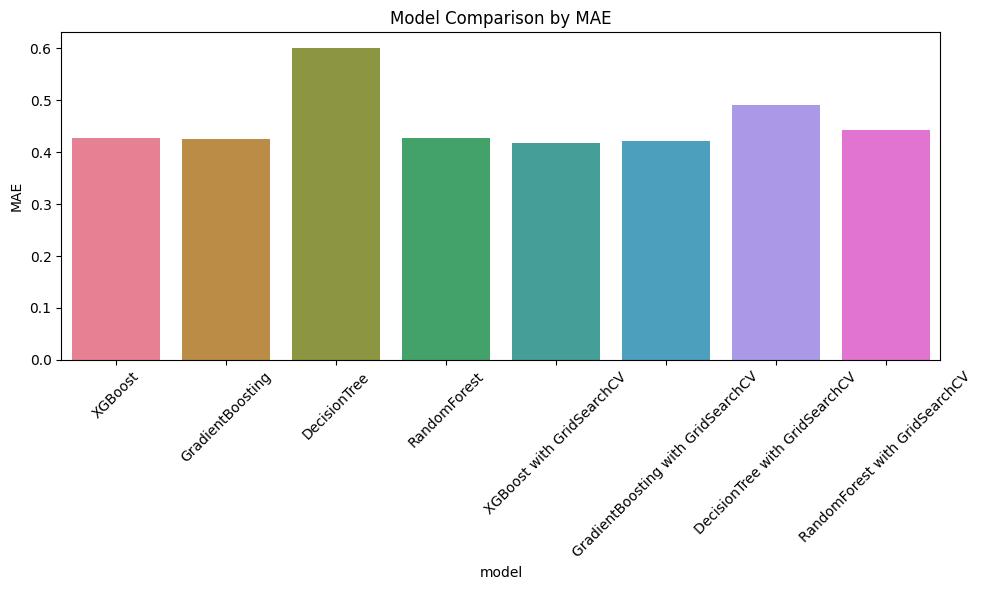

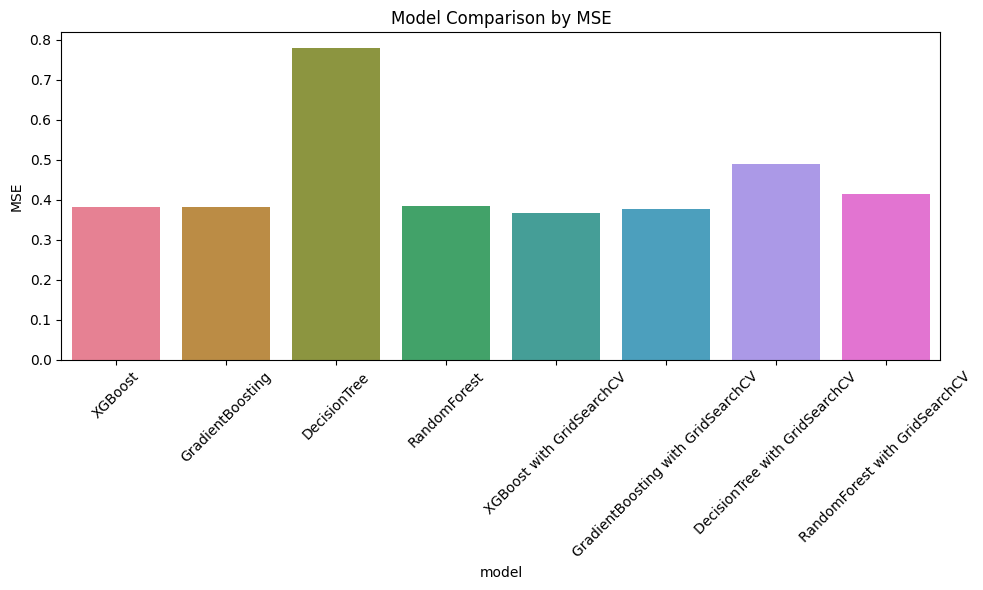

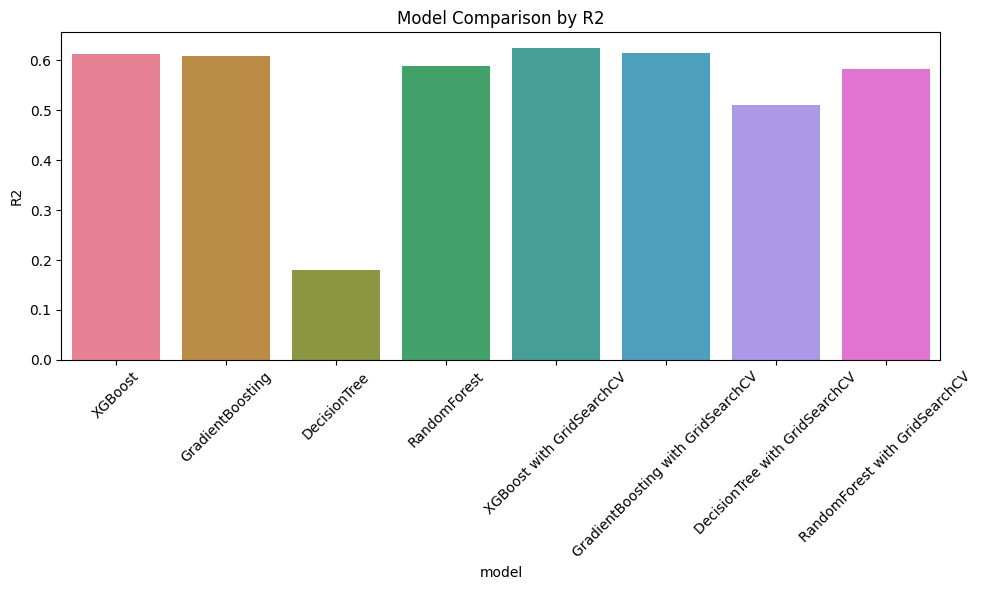

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='MAE', data=result_df, hue='model', palette='husl')
plt.title('Model Comparison by MAE')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='MSE', data=result_df, hue='model', palette='husl')
plt.title('Model Comparison by MSE')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='Mean R2', data=result_df, hue='model', palette='husl')
plt.title('Model Comparison by R2')
plt.ylabel('R2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'RandomForest with GridSearchCV')

<Figure size 1000x600 with 0 Axes>

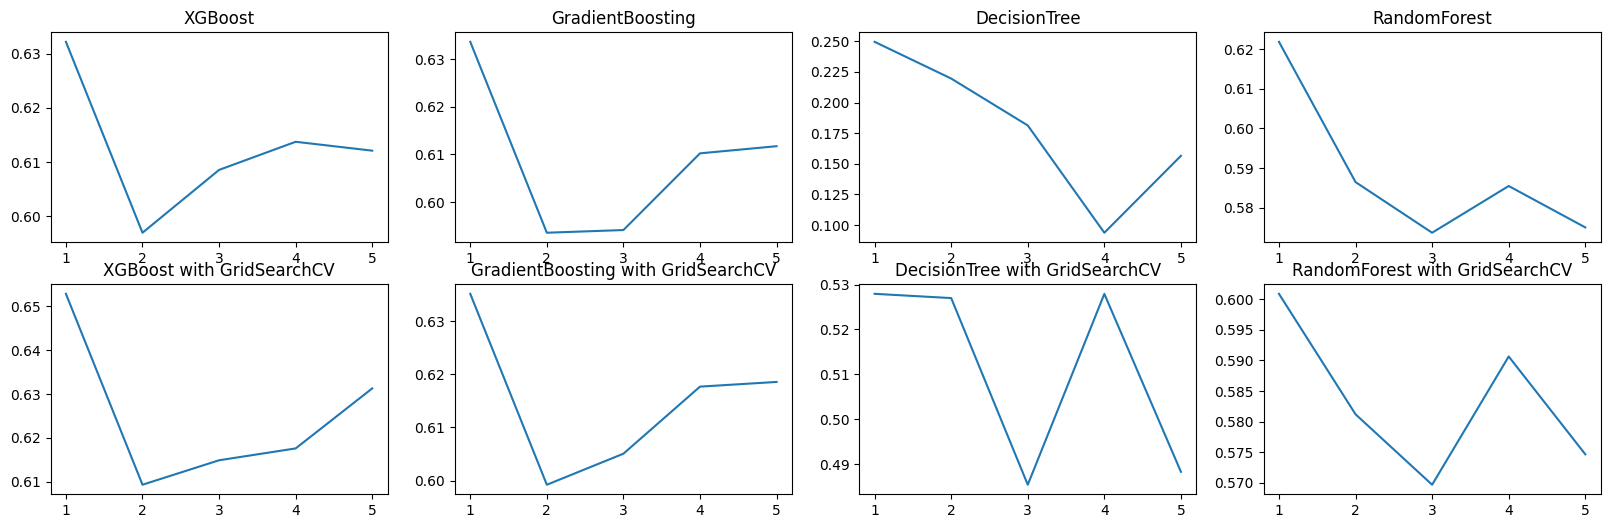

In [35]:
# Plot the cv scores of each cv for each model
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(2, 4, figsize=(20, 6))
# Using lineplot to show the R2 of each model at each cv
sns.lineplot(x=range(1, 6), y=scores_xgb, ax=axes[0, 0])
sns.lineplot(x=range(1, 6), y=scores_gbg, ax=axes[0, 1])
sns.lineplot(x=range(1, 6), y=scores_dt, ax=axes[0, 2])
sns.lineplot(x=range(1, 6), y=scores_rf, ax=axes[0, 3])
sns.lineplot(x=range(1, 6), y=scores_xgb_cv, ax=axes[1, 0])
sns.lineplot(x=range(1, 6), y=scores_gbg_cv, ax=axes[1, 1])
sns.lineplot(x=range(1, 6), y=scores_dt_cv, ax=axes[1, 2])
sns.lineplot(x=range(1, 6), y=scores_rf_cv, ax=axes[1, 3])

axes[0, 0].set_title('XGBoost')
axes[0, 1].set_title('GradientBoosting')
axes[0, 2].set_title('DecisionTree')
axes[0, 3].set_title('RandomForest')
axes[1, 0].set_title('XGBoost with GridSearchCV')
axes[1, 1].set_title('GradientBoosting with GridSearchCV')
axes[1, 2].set_title('DecisionTree with GridSearchCV')
axes[1, 3].set_title('RandomForest with GridSearchCV')




- Key insights
    - DecisionTree performs poorly across all metrics, standing out as a weak performer.
    - Ensemble models (XGBoost, GradientBoosting, RandomForest) are the top choices, with slight variations between tuned and untuned versions.
    - GridSearchCV versions of XGBoost, GradientBoosting, and RandomForest do not show a dramatic improvement over their default counterparts. However, their performance is consistent.
    - Consistency: Ensemble models outperform across all metrics, demonstrating their strength in handling complex patterns.

##### 3. Plot the predicted values vs true values of each model

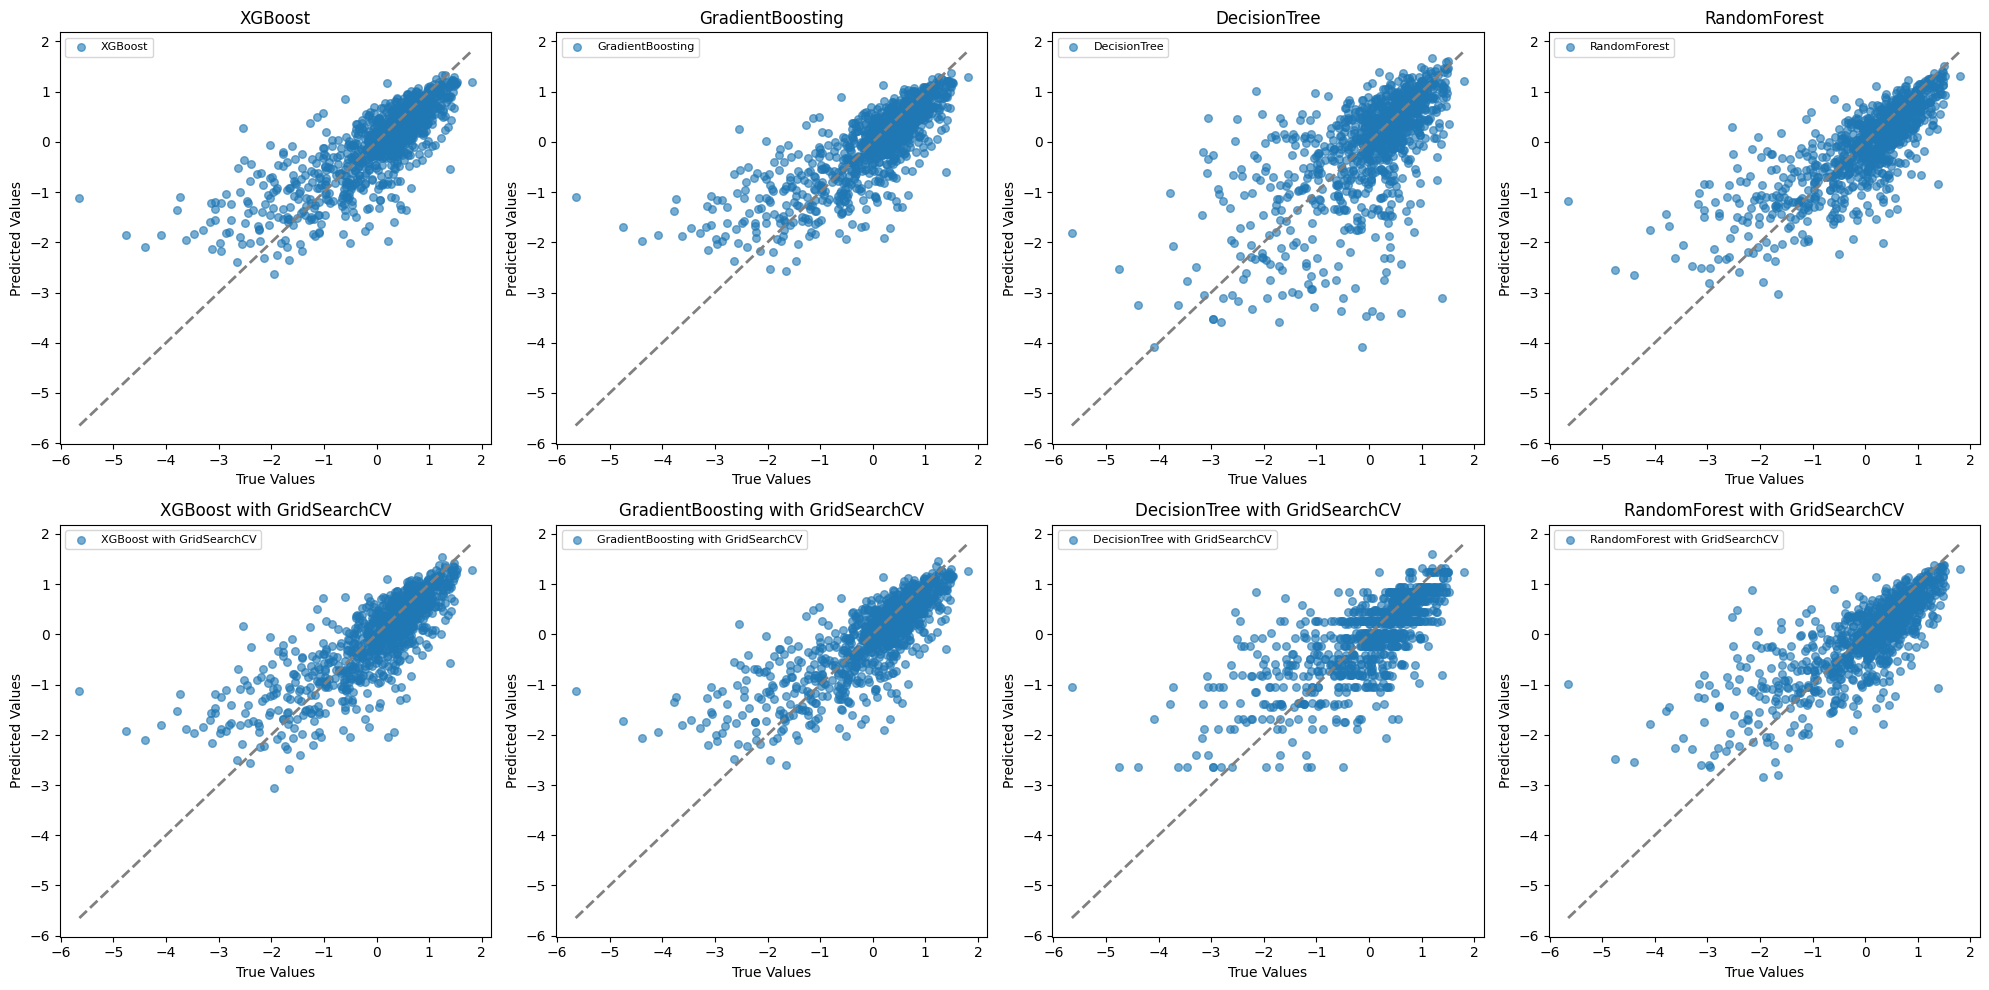

In [36]:
models = {
    "XGBoost": xgb,
    "GradientBoosting": gbg,
    "DecisionTree": dt,
    "RandomForest": rf,
    "XGBoost with GridSearchCV": xgb_cv_model,
    "GradientBoosting with GridSearchCV": gbg_cv_model,
    "DecisionTree with GridSearchCV": dt_cv_model,
    "RandomForest with GridSearchCV": rf_cv_model,
}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid of subplots
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for ax, (label, model) in zip(axes.ravel(), models.items()):
    ax.scatter(y_test, model.predict(X_test), alpha=0.6, label=label, s=30)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray', linewidth=2)
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("True Values", fontsize=10)
    ax.set_ylabel("Predicted Values", fontsize=10)
    ax.legend(fontsize=8)
plt.tight_layout()
plt.show()



- Best Performers:
    - XGBoost and GradientBoosting, both tuned and untuned, are the top models due to their tight clustering and alignment with the diagonal.
- Weakest Performer:
    - DecisionTree (both tuned and untuned) shows significant scatter and poor alignment, making it unsuitable for this dataset.
- Impact of Tuning:
    - GridSearchCV provides marginal improvements for ensemble models (GradientBoosting and RandomForest) but has minimal effect on XGBoost.
- Outliers:
    - All models exhibit some scatter at extreme values, though XGBoost handles these outliers best.

##### 4. Compare and point out disadvantages and advantages of each model (Emphasize on without and with using hyper-tuning)

| Model Name | Advantages (Without Tuning) | Disadvantages (Without Tuning) | Advantages (With Tuning) | Disadvantages (With Tuning)
|------------|---------------------------|--------------------------------|----------------------------|----------------------------|
| **XGBoost** | - Strong default performance due to powerful boosting mechanism. <br> - Handles missing data well (built-in mechanism). | - Prone to overfitting if parameters like max_depth, learning_rate are not tuned. <br> - Training time can be slower than other models with large datasets. | - Significantly optimized performance, especially on large datasets. <br> - Supports various optimization options, improving generalization. | - Resource-intensive tuning, requiring knowledge of parameters like n_estimators, max_depth, subsample, colsample_bytree. <br> - Can overfit to validation data if tuning is overdone. |
| **Gradient Boosting** | - Easy to implement, performs reasonably well with medium or small datasets. <br> - Suitable for regression or classification tasks with non-linear data. | - Performance may degrade on large datasets or without optimized parameters. <br> - Sensitive to outliers due to the lack of robust mechanisms for handling them. | - Increases accuracy by tuning learning_rate, n_estimators, and subsample. <br> - More flexible, minimizing overfitting/underfitting with better parameter control. | - Slower tuning process for large datasets due to sequential training nature. <br> - Challenging to manage if the importance of key parameters is not well understood. |
| **Decision Tree** | - Very fast, interpretable, no need for data normalization. <br> - Ideal for small tasks or when interpretability is crucial. | - Poor performance on complex data, prone to overfitting with default settings. <br> - Ineffective for large datasets, does not handle noisy or missing data well. | - Optimizing max_depth and min_samples_split significantly reduces overfitting. <br> - Can show noticeable improvement on small datasets after tuning. | - Overall performance still lags behind ensemble models (RF, XGB). <br> - Limited scalability for large or complex datasets. |
| **Random Forest** | - Stable performance, less prone to overfitting due to ensemble of multiple trees. <br> - Versatile, handles non-linear data well. | - Default parameters (n_estimators=100, max_depth=None) may lead to underfitting. <br> - Less interpretable compared to Decision Tree. | - Extremely robust when optimizing n_estimators, max_depth, and max_features. <br> - Suitable for large datasets, reduces sensitivity to outliers via averaging predictions across multiple trees. | - Computationally expensive to tune (many trees and parameter combinations). <br> - Training time can be significantly higher if n_estimators is set too high. |

**Conclusion**
- Without tuning:
    - Fast and sufficient for quick insights.
    - Performance may be suboptimal for complex datasets.
- With tuning:
    - Enhances performance significantly, especially for more sophisticated models like XGBoost and Gradient Boosting.
    - Requires more computational resources and expertise in parameter adjustment.

##### 5. Deploy with real test case (input) with all models and compare the differences


#### **Workflow** :
1. **Input Handling:**
    + User inputs are validated and processed into a single dictionary, which is then converted to a DataFrame for further processing.
    
2. **Feature Engineering:**
    + **Genres**: The reformat_genre function cleans up and standardizes genre strings. The one-hot encoding function maps each unique genre into binary features.
    + **Ratings**: Similar to genres, ratings are also one-hot encoded.
    + **Studios**: Studio names are fuzzily matched and one-hot encoded.
    + **Years and Months**: Years are bucketed into intervals and one-hot encoded, while months are categorized into custom ranges.

3. **Numerical Feature Scaling:**
    + Numerical features are scaled using a pre-fitted scaler (scaler_for_x).

4. **Prediction:**
    + The processed data is fed into an XGBoost (xgb) model. The predicted gross revenue is transformed back from the log scale.

+ Preproccess Sample Data Value Into Valid Input For Model Prediction

In [37]:

from difflib import SequenceMatcher
from difflib import get_close_matches

In [38]:
unique_studios = list(top_studios.index)
unique_studios.append('Other')

numerical_features = ['Tomatoes CriticScore', 'Tomatoes UserScore',
                      'Production Budget', 'Metascore', 'Meta UserScore']

# Standard scaler for numerical features
def match_string(str_1, str_2):
    # Use SequenceMatcher to compare the similarity of two strings
    ratio = SequenceMatcher(None, str_1, str_2).ratio()
    if ratio >= 0.9:
      return True
    return False

# Check if a string is in a list of strings
def string_isin(string, str_list):
    # Use get_close_matches to find similar strings
    matches = get_close_matches(string, str_list, cutoff = 0.9)
    if len(matches) > 0:
        return True
    return False

# Reformat the genre string
def reformat_genre(genre_string):
    # Remove unwanted characters and split the genre string into a list
    genre_string = genre_string.replace('[','').replace(']','').replace('"','')
    genre_list = [genre.strip().strip("'").lower() for genre in genre_string.split(',')]
    return genre_list

# One-hot encode the genre feature
def onehot_encode_genre(sample, unique_genres):

    # Reformat the genre string
    sample['Genre'] = sample['Genre'].apply(reformat_genre)

    # Convert the unique genres to lowercase
    unique_genres = [genre.lower() for genre in unique_genres]

    # One-hot encode the genre feature
    for genre in unique_genres:
        if any(match_string(genre, g) for g in sample['Genre'].values[0]):
            sample[f'Genre_{genre.capitalize()}'] = 1
        else:
            sample[f'Genre_{genre.capitalize()}'] = 0

    # If the genre is not in the unique genres, set 'Genre_Other' to 1
    sample['Genre_Other'] = 0
    for genre in sample['Genre'].values[0]:
        if not any(match_string(genre, unique_genre) for unique_genre in unique_genres):
            sample['Genre_Other'] = 1

    # Drop the original 'Genre' column
    sample = sample.drop(columns=['Genre'], axis=1)
    return sample

# One-hot encode the rating feature
def onehot_encode_rating(sample, unique_ratings):
    # Reformat the rating string
    sample['Rating'] = sample['Rating'].astype(str).str.lower()

    # Convert the unique ratings to lowercase
    unique_ratings = [rating.lower() for rating in unique_ratings]

    # One-hot encode the rating feature
    for rating in unique_ratings:
        if match_string(rating, sample['Rating'].values[0]):
            sample[f'Rating_{rating.capitalize()}'] = 1
        else:
            sample[f'Rating_{rating.capitalize()}'] = 0

    # If the rating is not in the unique ratings, set 'Rating_Unknown' to 1
    if not any(match_string(sample['Rating'].values[0], rating) for rating in unique_ratings):
        sample['Rating_Unknown'] = 1
    else:
        sample['Rating_Unknown'] = 0

    sample = sample.drop(columns=['Rating'], axis=1)
    return sample

# One-hot encode the year feature
def get_year_dict(year, min_year = 1929, max_year = 2024, bins=11):

    # Create bins for the years
    bin_edges = np.linspace(min_year, max_year, bins + 1)
    bin_labels = [f"Year_{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]

    year_dict = {}

    # Assign the year to the corresponding bin
    for i, label in enumerate(bin_labels):
        if bin_edges[i] <= year <= bin_edges[i+1]:
            year_dict[label] = 1
        else:
            year_dict[label] = 0

    return year_dict

# One-hot encode the year feature
def onehot_encode_year(sample, min_year = 1929, max_year = 2024, bins = 11):
    year_dict = get_year_dict(sample['Year'].values, min_year, max_year, bins)
    for label, value in year_dict.items():
        sample[label] = value
    sample = sample.drop(columns=['Year'], axis = 1)
    return sample

# One-hot encode the month feature
def get_month_dict(month):
  month_dict = {'Month_11_1' : 0, 'Month_2_4':0, 'Month_5_7':0, 'Month_8_10':0}
  if month in [12,11,1]:
    month_dict['Month_11_1'] = 1
  elif month in [2,3,4]:
    month_dict['Month_2_4'] = 1
  elif month in [5,6,7]:
    month_dict['Month_5_7'] = 1
  elif month in [8,9,10]:
    month_dict['Month_8_10'] = 1
  return month_dict

# One-hot encode the month feature
def onehot_encode_month(sample):
  month_dict = get_month_dict(sample['Month'].values)
  for key, value in month_dict.items():
    sample[key] = value
  sample = sample.drop(columns=['Month'], axis = 1)
  return sample

# One-hot encode the studio feature
def onehot_encode_studio(sample, unique_studios):

    # Reformat the studio string
    sample['Studio'] = sample['Studio'].astype(str).str.lower()
    unique_studios = [studio.lower() for studio in unique_studios]

    one_hot_columns = {}

    # One-hot encode the studio feature
    for studio in unique_studios:
        one_hot_columns[f'Studio_{studio.capitalize()}'] = sample['Studio'].apply(lambda x: 1 if match_string(studio, x) else 0)

    # If the studio is not in the unique studios, set 'Studio_Other' to 1
    if string_isin(sample['Studio'].values[0], unique_studios):
        one_hot_columns[f'Studio_Other'] = 0
    else:
        one_hot_columns[f'Studio_Other'] = 1

    one_hot_df = pd.DataFrame(one_hot_columns)

    sample = pd.concat([sample, one_hot_df], axis=1)

    sample = sample.drop(columns=['Studio'])

    return sample

# Scale the numerical features
def scale_dataset(sample, numerical_features = numerical_features, scaler = scaler_for_x):
    sample[numerical_features] = scaler.transform(sample[numerical_features])
    return sample

# Preprocess the input sample
def preprocess_input(sample, unique_genres = unique_genres, unique_ratings = unique_ratings, unique_studios = unique_studios, numerical_features = numerical_features, scaler = scaler_for_x, min_year=1929, max_year=2024,  bins=11):

    
    if 'Genre' in sample.columns:
        sample = onehot_encode_genre(sample, unique_genres)

    if 'Rating' in sample.columns:
        sample = onehot_encode_rating(sample, unique_ratings)

    if 'Studio' in sample.columns:
        sample = onehot_encode_studio(sample, unique_studios)

    if 'Year' in sample.columns:
        sample = onehot_encode_year(sample, min_year, max_year, bins)

    if 'Month' in sample.columns:
        sample = onehot_encode_month(sample)

    if numerical_features:
        sample = scale_dataset(sample, numerical_features=numerical_features, scaler=scaler)

    sample = sample[sorted(sample.columns)]

    return sample


+ Input Movie Data For Predicting

In [39]:
# Get input and check 
def get_valid_input(prompt, min, max):
  while True:
      try:
          value = float(input(prompt))
          if value == 0:
              return 0
          elif min <= value <= max:
              return value
          else:
              print(f"Invalid input! Please enter a value between {min} and {max}.")
      except ValueError:
          print("Invalid input! Please enter a numeric value.")

# Get genre input
def get_valid_genre(prompt):
    genre_input = input(prompt)
    genre_list = [genre.strip() for genre in genre_input.split(',')]
    genre_list = list(set(genre_list))
    genre_str = "["
    for genre in genre_list:
        genre_str += f'"{genre}",'
    genre_str = genre_str[:-1] + "]"
    return genre_str

# Input movie data for prediction
def input_movie_data():
    # Get user inputs for each column
    critic_score = get_valid_input("Enter Tomatoes CriticScore (press 0 to skip): ", min = 0, max = 100)
    user_score = get_valid_input("Enter Tomatoes UserScore  (press 0 to skip): ", min = 0, max = 100)
    metascore = get_valid_input("Enter Metascore  (press 0 to skip): ", min = 0, max = 100)
    meta_user_score = get_valid_input("Enter Meta UserScore  (press 0 to skip): ", min = 0, max = 100)
    production_budget = get_valid_input("Enter Production Budget $  (press 0 to skip): ", min = 0, max = np.finfo(np.float32).max)
    production_budget = np.log(production_budget+1)

    genre = get_valid_genre("Enter Genre (e.g., 'Action, Adventure, Comedy'): ")
    
    rating = input("Enter Rating (e.g., R, PG-13): ")

    studio = input("Enter Studio: ")

    year = get_valid_input("Enter Year: ", min = 1929, max = 2024)

    month = 0
    while(month == 0):
      month = get_valid_input("Enter Month (press 1 to skip): ", min = 1, max = 12)
      if month == 0:
        print("Invalid month")

    # Create a dictionary to store the data
    movie_data = {
        "Tomatoes CriticScore": critic_score,
        "Tomatoes UserScore": user_score,
        "Production Budget": production_budget,
        "Metascore": metascore,
        "Meta UserScore": meta_user_score,
        "Genre": genre,
        "Rating": rating,
        "Studio": studio,
        "Year": year,
        "Month": month
    }

    return pd.DataFrame([movie_data])

+ Input Data

In [40]:

# movie = input_movie_data()
# movie

+ Predict Gross

In [41]:
# sample = preprocess_input(movie)
# y_pred = xgb.predict(sample.values)
# y_pred = scaler_for_y.inverse_transform(y_pred.reshape(-1, 1))[0][0]

# print("Predicted Total Gross : ", np.exp(y_pred) - 1)

##### 6. Which model is the best and why ?

In [42]:
result_df = result_df.drop(columns=['R2'])

In [43]:

print("Model with the best MAE:")
display(result_df.sort_values(by='MAE', ascending=True).head(1))
print("Model with the best MSE:")
display(result_df.sort_values(by='MSE', ascending=True).head(1))
print("Model with the best Mean R2:")
display(result_df.sort_values(by='Mean R2', ascending=False).head(1))

Model with the best MAE:


,model,MAE,MSE,Mean R2
4,XGBoost with GridSearchCV,0.417754,0.365888,0.625187


Model with the best MSE:


,model,MAE,MSE,Mean R2
4,XGBoost with GridSearchCV,0.417754,0.365888,0.625187


Model with the best Mean R2:


,model,MAE,MSE,Mean R2
4,XGBoost with GridSearchCV,0.417754,0.365888,0.625187


→ The two best models that can be compared are: GradientBoosting with GridSearchCV and XGBoost with GridSearchCV	

In [44]:
from scipy.stats import ttest_rel

mean_r2_model1 = cross_val_score(xgb_cv_model, X, y, scoring='r2', cv=cv)
mean_r2_model2 = cross_val_score(gbg_cv_model, X, y, scoring='r2', cv=cv)

t_stat, p_val = ttest_rel(mean_r2_model1, mean_r2_model2)
print("Paired t-test p-value:", p_val)

if p_val < 0.05: 
    print("The difference between the models is statistically significant.")
else:
    print("The difference between the models is not statistically significant.")

Paired t-test p-value: 0.025343666349121805
The difference between the models is statistically significant.


→ The difference in Mean R2 between the two models is not statistically significant, meaning there is almost no difference in scores between these two models.

#### **A comprehensive comparison of two models: Gradient Boosting with GridSearchCV and XGBoost with GridSearchCV.**
1. **Prediction Performance (MAE, MSE, Mean R²)**

    - MAE (Mean Absolute Error):
        - GradientBoosting: ~ (0.41 - 0.43) (1% better)
        - XGBoost: ~ (0.41 - 0.43)

    - MSE (Mean Squared Error):
        - GradientBoosting: ~ 0.364 (1% better)
        - XGBoost: ~ 0.368

    - Mean R²:
        - GradientBoosting: ~ 0.619
        - XGBoost: ~ 0.622 (0.5% better)

    - Analysis:
        - MAE and MSE:
            - GradientBoosting has slightly lower MAE and MSE, but the difference is still small (~ 1%), meaning the model tends to make slightly more accurate predictions with smaller errors.
        - Mean R²:
            - XGBoost has a slightly higher Mean R², but the difference is still small (~ 0.5%). This indicates that XGBoost explains a marginally higher proportion of the variance in the data, but the difference is statistically insignificant (most p-value > 0.05).

2. **Training Time**
    - XGBoost with GridSearchCV: ~ 18s
    - GradientBoosting with GridSearchCV: ~ 35s
    - Analysis:
        - XGBoost is now almost twice as fast as GradientBoosting in training time (18s vs. 35s). This makes XGBoost significantly more efficient, especially when multiple models are being trained or when there are time constraints for model iteration.

3. **Stability and Reproducibility (Cross-validation)**
    - Both models were run with GridSearchCV, which optimizes hyperparameters and ensures stable performance across different data folds. The results show that both models exhibit consistent performance across cross-validation.

4. **Ease of Deployment and Maintenance**
    - XGBoost: Due to its faster training time and efficient hyperparameter optimization, XGBoost is often more suitable in production environments where model training speed is important.
    - GradientBoosting: While it provides slightly more accurate predictions, its longer training time can make it less practical when quick results or frequent model updates are needed.

#### **Conclusion**:
1. **Prediction Performance**:
    - GradientBoosting has slightly lower MAE and MSE, indicating it can achieve marginally more accurate predictions. However, the difference in prediction accuracy between the two models is small and likely negligible in most practical scenarios.
    - XGBoost performs similarly with a slightly higher Mean R², but the difference is very minor and statistically insignificant.
2. **Training Time**:
    - XGBoost is significantly faster than GradientBoosting, with training times of 18s compared to 35s. This makes XGBoost more efficient for rapid iterations or deployment, especially when working with larger datasets.
3. **Final Decision**:
    - XGBoost offers almost identical performance to GradientBoosting in terms of prediction accuracy but is much faster in training, making it the better choice for time-sensitive tasks or larger datasets.

**→ Thus, XGBoost stands out as the better choice when considering both model performance and efficiency.**